<a href="https://www.kaggle.com/code/adegbaju/credit-card-fraud-detection-complete-code?scriptVersionId=296786819" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# CREDIT CARD FRAUD DETECTION - COMPLETE CODE

In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn xgboost lightgbm tensorflow joblib

Note: you may need to restart the kernel to use updated packages.


In [2]:


# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import time
from sklearn.metrics import auc
from sklearn.neighbors import LocalOutlierFactor
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           precision_recall_curve, average_precision_score, roc_curve,
                           f1_score, recall_score, precision_score, accuracy_score)

# Imbalanced learning
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import LocalOutlierFactor
import joblib

# Deep Learning (optional)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, Model
    TF_AVAILABLE = True
except:
    TF_AVAILABLE = False
    print("TensorFlow not available. Skipping neural network models.")

# Set random seeds for reproducibility
np.random.seed(42)
if TF_AVAILABLE:
    tf.random.set_seed(42)

2026-02-09 18:23:07.466175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770661387.683788      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770661387.746966      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770661388.276851      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770661388.276893      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770661388.276896      17 computation_placer.cc:177] computation placer alr

#  DATA LOADING & INITIAL EXPLORATION

In [3]:
def load_and_explore_data(filepath=r'/kaggle/input/credit-card-fraud-data/fraudTest.csv'):
    """
    Load the dataset and perform initial exploration
    """
    print("Loading dataset...")
    df = pd.read_csv(filepath)
    
    print(f"Dataset Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    # Display basic info
    print("\n" + "="*50)
    print("DATASET INFORMATION")
    print("="*50)
    print(df.info())
    
    # Check for missing values
    print("\n" + "="*50)
    print("MISSING VALUES")
    print("="*50)
    missing_values = df.isnull().sum()
    print(missing_values[missing_values > 0])
    
    # Check target variable distribution (assuming it's named 'is_fraud' or similar)
    # We need to identify the target column
    target_candidates = ['is_fraud', 'fraud', 'Class', 'target', 'label']
    target_col = None
    for col in target_candidates:
        if col in df.columns:
            target_col = col
            break
    
    if target_col is None:
        # Try to find binary column
        binary_cols = [col for col in df.columns if df[col].nunique() == 2]
        if binary_cols:
            target_col = binary_cols[0]
            print(f"\nTarget column not found. Using '{target_col}' as target (binary column)")
        else:
            raise ValueError("Could not identify target column")
    
    print(f"\nTarget column identified: '{target_col}'")
    
    # Check class distribution
    print("\n" + "="*50)
    print("CLASS DISTRIBUTION")
    print("="*50)
    class_dist = df[target_col].value_counts()
    print(class_dist)
    print(f"\nFraud percentage: {class_dist[1]/len(df)*100:.4f}%")
    
    # Display sample of data
    print("\n" + "="*50)
    print("DATA SAMPLE")
    print("="*50)
    print(df.head())
    
    return df, target_col

# DATA PREPROCESSING & FEATURE ENGINEERING

In [4]:
def preprocess_data(df, target_col):
    """
    Preprocess the data and create new features
    """
    df_processed = df.copy()
    
    print("\n" + "="*50)
    print("DATA PREPROCESSING")
    print("="*50)
    
    # 1. Drop unique identifier columns that can't be used as features
    columns_to_drop_immediately = ['sn', 'trans_num', 'first', 'last', 'street', 'city', 'job', 'dob']
    for col in columns_to_drop_immediately:
        if col in df_processed.columns:
            df_processed.drop(col, axis=1, inplace=True)
            print(f"Dropped {col}")
    
    # 2. Extract features from datetime
    if 'trans_date_trans_time' in df_processed.columns:
        print("Extracting datetime features...")
        df_processed['trans_date_trans_time'] = pd.to_datetime(df_processed['trans_date_trans_time'])
        df_processed['hour'] = df_processed['trans_date_trans_time'].dt.hour
        df_processed['day_of_week'] = df_processed['trans_date_trans_time'].dt.dayofweek
        df_processed['day_of_month'] = df_processed['trans_date_trans_time'].dt.day
        df_processed['month'] = df_processed['trans_date_trans_time'].dt.month
        df_processed['is_weekend'] = (df_processed['day_of_week'] >= 5).astype(int)
        
        # Create time-based features
        df_processed['hour_sin'] = np.sin(2 * np.pi * df_processed['hour']/24)
        df_processed['hour_cos'] = np.cos(2 * np.pi * df_processed['hour']/24)
        
        # Drop the original datetime column
        df_processed.drop('trans_date_trans_time', axis=1, inplace=True)
    
    # 3. Handle categorical variables
    categorical_cols = ['category', 'gender', 'merchant', 'state']
    for col in categorical_cols:
        if col in df_processed.columns:
            print(f"Encoding {col}...")
            le = LabelEncoder()
            df_processed[f'{col}_encoded'] = le.fit_transform(df_processed[col].astype(str))
            df_processed.drop(col, axis=1, inplace=True)
    
    # 4. Create transaction amount features
    if 'amt' in df_processed.columns:
        print("Creating amount-based features...")
        # Handle zero or negative amounts
        df_processed['amt_log'] = np.log1p(df_processed['amt'].clip(lower=0))
        df_processed['amt_scaled'] = (df_processed['amt'] - df_processed['amt'].mean()) / df_processed['amt'].std()
    
    # 5. Create customer behavior features
    if 'cc_num' in df_processed.columns:
        print("Creating customer behavior features...")
        # Convert cc_num to string for grouping
        df_processed['cc_num_str'] = df_processed['cc_num'].astype(str)
        
        # Transaction frequency per card
        transaction_counts = df_processed['cc_num_str'].value_counts().to_dict()
        df_processed['transaction_freq'] = df_processed['cc_num_str'].map(transaction_counts)
        
        # Average amount per card
        avg_amount = df_processed.groupby('cc_num_str')['amt'].mean().to_dict()
        df_processed['avg_amount_per_card'] = df_processed['cc_num_str'].map(avg_amount)
        
        # Amount deviation from average
        df_processed['amt_deviation'] = abs(df_processed['amt'] - df_processed['avg_amount_per_card'])
        
        # Drop temporary column
        df_processed.drop('cc_num_str', axis=1, inplace=True)
        df_processed.drop('cc_num', axis=1, inplace=True)
    
    # 6. Create merchant risk features
    if 'merchant_encoded' in df_processed.columns:
        print("Creating merchant risk features...")
        # Calculate fraud rate per merchant (using encoded version)
        merchant_fraud_rate = df_processed.groupby('merchant_encoded')[target_col].mean().to_dict()
        df_processed['merchant_fraud_rate'] = df_processed['merchant_encoded'].map(merchant_fraud_rate)
        
        # Transaction count per merchant
        merchant_counts = df_processed['merchant_encoded'].value_counts().to_dict()
        df_processed['merchant_transaction_count'] = df_processed['merchant_encoded'].map(merchant_counts)
    
    # 7. Create category risk features
    if 'category_encoded' in df_processed.columns:
        print("Creating category risk features...")
        category_fraud_rate = df_processed.groupby('category_encoded')[target_col].mean().to_dict()
        df_processed['category_fraud_rate'] = df_processed['category_encoded'].map(category_fraud_rate)
    
    # 8. Create location-based features
    if all(col in df_processed.columns for col in ['lat', 'long', 'merch_lat', 'merch_long']):
        print("Creating location-based features...")
        # Calculate distance between cardholder and merchant location
        df_processed['distance'] = np.sqrt(
            (df_processed['lat'] - df_processed['merch_lat'])**2 +
            (df_processed['long'] - df_processed['merch_long'])**2
        )
        
        # Create location mismatch flag
        df_processed['location_mismatch'] = (df_processed['distance'] > 1).astype(int)
    
    # 9. Create time-based patterns
    if 'unix_time' in df_processed.columns:
        print("Creating time-based patterns...")
        # Time since last transaction (per card) - we'll approximate
        df_processed['unix_time'] = pd.to_numeric(df_processed['unix_time'], errors='coerce')
        df_processed = df_processed.sort_values('unix_time')
        
        # Time of day categories
        df_processed['time_of_day'] = pd.cut(df_processed['hour'], 
                                           bins=[0, 6, 12, 18, 24],
                                           labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                                           include_lowest=True)
        
        # Encode time_of_day
        le_time = LabelEncoder()
        df_processed['time_of_day_encoded'] = le_time.fit_transform(df_processed['time_of_day'].astype(str))
        df_processed.drop('time_of_day', axis=1, inplace=True)
    
    # 10. Create city population features
    if 'city_pop' in df_processed.columns:
        print("Creating city population features...")
        df_processed['city_pop_log'] = np.log1p(df_processed['city_pop'])
        df_processed['is_small_city'] = (df_processed['city_pop'] < 10000).astype(int)
    
    # 11. Drop any remaining non-numeric columns
    non_numeric_cols = df_processed.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        print(f"Dropping non-numeric columns: {list(non_numeric_cols)}")
        df_processed = df_processed.select_dtypes(include=[np.number])
    
    # 12. Handle any infinite or NaN values
    df_processed = df_processed.replace([np.inf, -np.inf], np.nan)
    df_processed = df_processed.fillna(0)
    
    print(f"\nOriginal features: {len(df.columns)}")
    print(f"Features after preprocessing: {len(df_processed.columns)}")
    print(f"\nFeature types:")
    print(df_processed.dtypes.value_counts())
    
    return df_processed

# EXPLORATORY DATA ANALYSIS

In [5]:
def perform_eda(df, target_col):
    """
    Perform exploratory data analysis
    """
    print("\n" + "="*50)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*50)
    
    # Create visualizations
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Class distribution
    ax1 = axes[0, 0]
    class_counts = df[target_col].value_counts()
    colors = ['#1f77b4', '#ff7f0e']
    ax1.pie(class_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%', 
            colors=colors, startangle=90)
    ax1.set_title('Class Distribution')
    
    # 2. Transaction amount distribution
    ax2 = axes[0, 1]
    ax2.hist(df['amt'][df[target_col] == 0], bins=50, alpha=0.7, label='Non-Fraud', color='blue')
    ax2.hist(df['amt'][df[target_col] == 1], bins=50, alpha=0.7, label='Fraud', color='red')
    ax2.set_xlabel('Transaction Amount')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Transaction Amount Distribution')
    ax2.legend()
    ax2.set_yscale('log')
    
    # 3. Fraud by hour
    if 'hour' in df.columns:
        ax3 = axes[0, 2]
        fraud_by_hour = df[df[target_col] == 1].groupby('hour').size()
        non_fraud_by_hour = df[df[target_col] == 0].groupby('hour').size()
        ax3.plot(fraud_by_hour.index, fraud_by_hour.values, 'r-', label='Fraud', linewidth=2)
        ax3.plot(non_fraud_by_hour.index, non_fraud_by_hour.values/non_fraud_by_hour.max()*fraud_by_hour.max(), 
                'b--', label='Non-Fraud (scaled)', alpha=0.7)
        ax3.set_xlabel('Hour of Day')
        ax3.set_ylabel('Transaction Count')
        ax3.set_title('Transactions by Hour')
        ax3.legend()
    
    # 4. Fraud by category
    if 'category_encoded' in df.columns:
        ax4 = axes[1, 0]
        category_fraud = df.groupby('category_encoded')[target_col].mean().sort_values(ascending=False)
        category_fraud.head(10).plot(kind='bar', ax=ax4, color='red')
        ax4.set_xlabel('Category')
        ax4.set_ylabel('Fraud Rate')
        ax4.set_title('Fraud Rate by Category')
        ax4.tick_params(axis='x', rotation=45)
    
    # 5. Correlation matrix (top features)
    ax5 = axes[1, 1]
    # Select numeric columns for correlation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    corr_matrix = df[numeric_cols].corr()
    # Get correlations with target
    target_corr = corr_matrix[target_col].sort_values(ascending=False)
    target_corr.drop(target_col, inplace=True)
    target_corr.head(10).plot(kind='bar', ax=ax5, color='green')
    ax5.set_xlabel('Features')
    ax5.set_ylabel('Correlation with Target')
    ax5.set_title('Top Feature Correlations with Fraud')
    ax5.tick_params(axis='x', rotation=45)
    
    # 6. Amount vs Fraud scatter
    ax6 = axes[1, 2]
    sample_size = min(1000, len(df))
    sample_df = df.sample(sample_size, random_state=42)
    colors = ['blue' if x == 0 else 'red' for x in sample_df[target_col]]
    ax6.scatter(sample_df.index[:sample_size], sample_df['amt'][:sample_size], 
                c=colors, alpha=0.6, s=30)
    ax6.set_xlabel('Transaction Index')
    ax6.set_ylabel('Amount')
    ax6.set_title('Transaction Amounts (Blue=Normal, Red=Fraud)')
    
    plt.tight_layout()
    plt.show()
    
    # Additional statistics
    print("\nFRAUD STATISTICS:")
    print("-" * 30)
    fraud_data = df[df[target_col] == 1]
    non_fraud_data = df[df[target_col] == 0]
    
    if 'amt' in df.columns:
        print(f"Average Fraud Amount: ${fraud_data['amt'].mean():.2f}")
        print(f"Average Non-Fraud Amount: ${non_fraud_data['amt'].mean():.2f}")
        print(f"Max Fraud Amount: ${fraud_data['amt'].max():.2f}")
    
    if 'hour' in df.columns:
        print(f"Most Common Fraud Hour: {fraud_data['hour'].mode().values[0]}")
    
    return fig

# DATA PREPARATION FOR MODELING

In [6]:
def prepare_data_for_modeling(df_processed, target_col, test_size=0.2):
    """
    Split data and handle class imbalance
    """
    print("\n" + "="*50)
    print("DATA PREPARATION FOR MODELING")
    print("="*50)
    
    # Separate features and target
    X = df_processed.drop(target_col, axis=1)
    y = df_processed[target_col]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Training fraud rate: {y_train.mean():.4%}")
    print(f"Test fraud rate: {y_test.mean():.4%}")
    
    return X_train, X_test, y_train, y_test

def handle_class_imbalance(X_train, y_train, method='smote'):
    """
    Apply techniques to handle class imbalance
    """
    print(f"\nApplying {method.upper()} to handle class imbalance...")
    
    # Convert to numpy arrays to avoid issues with pandas
    X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
    y_train_np = y_train.values if hasattr(y_train, 'values') else y_train
    
    # Calculate class imbalance ratio for reference
    fraud_rate = np.mean(y_train_np)
    print(f"Original fraud rate: {fraud_rate:.6f} ({fraud_rate*100:.4f}%)")
    
    if method == 'smote':
        # For highly imbalanced data, use a small k_neighbors
        n_minority = int(np.sum(y_train_np))
        k_neighbors = min(5, n_minority - 1) if n_minority > 1 else 1
        
        print(f"Using SMOTE with k_neighbors={k_neighbors}")
        sampler = SMOTE(
            random_state=42, 
            k_neighbors=k_neighbors,
            sampling_strategy='auto'
        )
    elif method == 'adasyn':
        n_minority = int(np.sum(y_train_np))
        n_neighbors = min(5, n_minority - 1) if n_minority > 1 else 1
        
        print(f"Using ADASYN with n_neighbors={n_neighbors}")
        sampler = ADASYN(
            random_state=42, 
            n_neighbors=n_neighbors,
            sampling_strategy='auto'
        )
    elif method == 'smotetomek':
        sampler = SMOTETomek(random_state=42, sampling_strategy='auto')
    elif method == 'undersample':
        sampler = RandomUnderSampler(
            random_state=42,
            sampling_strategy=0.1  # 10% minority class
        )
    elif method == 'hybrid':
        # Combine SMOTE with undersampling
        from imblearn.pipeline import Pipeline as ImbPipeline
        
        sampler = ImbPipeline([
            ('smote', SMOTE(random_state=42, sampling_strategy=0.1)),
            ('undersample', RandomUnderSampler(random_state=42, sampling_strategy=0.5))
        ])
    elif method == 'none':
        return X_train, y_train
    else:
        raise ValueError(f"Unknown method: {method}")
    
    try:
        X_resampled, y_resampled = sampler.fit_resample(X_train_np, y_train_np)
        print(f"Before resampling: {X_train_np.shape}, Fraud rate: {fraud_rate:.6%}")
        print(f"After resampling: {X_resampled.shape}, Fraud rate: {np.mean(y_resampled):.6%}")
        
        # Convert back to pandas if input was pandas
        if hasattr(X_train, 'columns'):
            X_resampled = pd.DataFrame(X_resampled, columns=X_train.columns)
            y_resampled = pd.Series(y_resampled, name=y_train.name)
            
        return X_resampled, y_resampled
        
    except Exception as e:
        print(f"Error in {method}: {str(e)}")
        print("Falling back to class weights instead...")
        return X_train, y_train

#  MODEL BUILDING & TRAINING

In [7]:
def create_models():
    """
    Create dictionary of models to evaluate
    """
    # Calculate class weights for imbalanced data
    # This helps models handle the imbalance without resampling
    models = {
        'Logistic Regression': LogisticRegression(
            class_weight='balanced',
            random_state=42,
            max_iter=1000,
            solver='liblinear'
        ),
        'Random Forest': RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_estimators=100,
            n_jobs=-1,
            max_depth=10
        ),
        'Balanced Random Forest': BalancedRandomForestClassifier(
            random_state=42,
            n_estimators=100,
            n_jobs=-1,
            max_depth=10
        ),
        'XGBoost': XGBClassifier(
            scale_pos_weight=100,  # High weight for minority class
            random_state=42,
            n_jobs=-1,
            eval_metric='logloss',
            max_depth=6,
            learning_rate=0.1
        ),
        'LightGBM': LGBMClassifier(
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=-1,
            max_depth=6,
            learning_rate=0.1,
            n_estimators=100
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42,
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1
        ),
        'Isolation Forest': IsolationForest(
            random_state=42,
            n_jobs=-1,
            max_samples='auto'
        )
    }
    
    return models

def train_and_evaluate_models(X_train, X_test, y_train, y_test, sampling_method='smote'):
    """
    Train multiple models and evaluate their performance
    """
    print("\n" + "="*50)
    print("MODEL TRAINING & EVALUATION")
    print("="*50)
    
    # Handle class imbalance
    X_train_resampled, y_train_resampled = handle_class_imbalance(X_train, y_train, sampling_method)
    
    # Get models
    models = create_models()
    
    # Standardize features (for models that need it)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    results = {}
    trained_models = {}
    
    for name, model in models.items():
        print(f"\n{'='*30}")
        print(f"Training {name}...")
        print(f"{'='*30}")
        
        try:
            start_time = time.time()
            
            # Special handling for anomaly detection models
            if name == 'Isolation Forest':
                # For isolation forest, we need to specify contamination
                contamination = y_train.mean()  # Approximate fraud rate
                model.set_params(contamination=contamination)
                
                model.fit(X_train_scaled)
                y_pred = model.predict(X_test_scaled)
                # Convert to 0/1 (1 for fraud/outlier, 0 for normal)
                y_pred = [1 if x == -1 else 0 for x in y_pred]
                y_pred_proba = model.decision_function(X_test_scaled)
                # Convert decision function to probability-like scores
                y_pred_proba = 1 / (1 + np.exp(-y_pred_proba))
            elif name == 'Local Outlier Factor':
                # LOF also needs special handling
                from sklearn.neighbors import LocalOutlierFactor
                contamination = y_train.mean()
                model = LocalOutlierFactor(
                    contamination=contamination,
                    novelty=True,
                    n_jobs=-1
                )
                model.fit(X_train_scaled)
                y_pred = model.predict(X_test_scaled)
                y_pred = [1 if x == -1 else 0 for x in y_pred]
                y_pred_proba = model.decision_function(X_test_scaled)
                y_pred_proba = 1 / (1 + np.exp(-y_pred_proba))
            else:
                # Regular supervised models
                model.fit(X_train_scaled, y_train_resampled)
                y_pred = model.predict(X_test_scaled)
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            
            elapsed_time = time.time() - start_time
            
            # Calculate metrics
            results[name] = calculate_metrics(y_test, y_pred, y_pred_proba)
            results[name]['training_time'] = elapsed_time
            
            print(f"Training time: {elapsed_time:.2f}s")
            print(f"Accuracy: {results[name]['accuracy']:.4f}")
            print(f"Precision: {results[name]['precision']:.4f}")
            print(f"Recall: {results[name]['recall']:.4f}")
            print(f"F1-Score: {results[name]['f1']:.4f}")
            print(f"ROC-AUC: {results[name]['roc_auc']:.4f}")
            print(f"PR-AUC: {results[name]['pr_auc']:.4f}")
            
            # Store trained model
            trained_models[name] = model
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
            import traceback
            traceback.print_exc()
            results[name] = None
    
    return results, trained_models


def calculate_metrics(y_true, y_pred, y_pred_proba):
    """
    Calculate comprehensive evaluation metrics
    """
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1': f1_score(y_true, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_true, y_pred_proba),
        'confusion_matrix': confusion_matrix(y_true, y_pred)
    }
    
    # Calculate precision-recall AUC
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    metrics['pr_auc'] = auc(recall, precision)
    
    # Classification report
    metrics['classification_report'] = classification_report(y_true, y_pred, output_dict=True)
    
    return metrics

# MODEL EVALUATION & VISUALIZATION

In [8]:
def plot_model_comparison(results):
    """
    Create visualizations comparing model performance
    """
    print("\n" + "="*50)
    print("MODEL COMPARISON VISUALIZATION")
    print("="*50)
    
    # Filter out None results
    valid_results = {k: v for k, v in results.items() if v is not None}
    
    if not valid_results:
        print("No valid results to plot")
        return
    
    metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx]
        model_names = list(valid_results.keys())
        metric_values = [valid_results[name][metric] for name in model_names]
        
        bars = ax.barh(model_names, metric_values, color='skyblue')
        ax.set_xlabel(metric.replace('_', ' ').title())
        ax.set_title(f'{metric.replace("_", " ").title()} Comparison')
        
        # Add value labels
        for bar, value in zip(bars, metric_values):
            ax.text(value, bar.get_y() + bar.get_height()/2, 
                   f'{value:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Plot confusion matrices for top 3 models
    top_models = sorted(valid_results.items(), key=lambda x: x[1]['f1'], reverse=True)[:3]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for idx, (name, metrics) in enumerate(top_models):
        ax = axes[idx]
        cm = metrics['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=['Predicted Normal', 'Predicted Fraud'],
                   yticklabels=['Actual Normal', 'Actual Fraud'])
        ax.set_title(f'{name}\nF1-Score: {metrics["f1"]:.3f}')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*60)
    print("DETAILED MODEL COMPARISON")
    print("="*60)
    print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'ROC-AUC':<10}")
    print("-" * 75)
    
    for name, metrics in valid_results.items():
        print(f"{name:<25} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} {metrics['f1']:<10.4f} {metrics['roc_auc']:<10.4f}")

# HYPERPARAMETER TUNING

In [9]:
def hyperparameter_tuning(X_train, y_train, model_name='XGBoost'):
    """
    Perform hyperparameter tuning for selected model
    """
    print(f"\n{'='*50}")
    print(f"HYPERPARAMETER TUNING FOR {model_name}")
    print(f"{'='*50}")
    
    # Handle class imbalance
    X_resampled, y_resampled = handle_class_imbalance(X_train, y_train)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_resampled)
    
    # Define parameter grids for different models
    param_grids = {
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0],
            'scale_pos_weight': [5, 10, 20]
        },
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': ['balanced', 'balanced_subsample']
        },
        'Logistic Regression': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    }
    
    if model_name not in param_grids:
        print(f"No parameter grid defined for {model_name}")
        return None
    
    # Create base model
    if model_name == 'XGBoost':
        base_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
    elif model_name == 'Random Forest':
        base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    elif model_name == 'Logistic Regression':
        base_model = LogisticRegression(random_state=42, max_iter=1000)
    else:
        return None
    
    # Perform GridSearchCV
    print(f"Performing grid search for {model_name}...")
    grid_search = GridSearchCV(
        base_model,
        param_grids[model_name],
        cv=3,  # Fewer folds for speed
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_scaled, y_resampled)
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best F1-Score: {grid_search.best_score_:.4f}")
    
    return grid_search.best_estimator_


#  DEEP LEARNING MODEL 

In [10]:
def create_deep_learning_model(input_dim):
    """
    Create a neural network for fraud detection
    """
    if not TF_AVAILABLE:
        print("TensorFlow not available. Skipping neural network.")
        return None
    
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_dim=input_dim),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        layers.Dense(16, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='roc_auc'),
            keras.metrics.AUC(name='pr_auc', curve='PR')
        ]
    )
    
    return model

def train_deep_learning_model(X_train, X_test, y_train, y_test):
    """
    Train and evaluate deep learning model
    """
    if not TF_AVAILABLE:
        return None
    
    print("\n" + "="*50)
    print("DEEP LEARNING MODEL")
    print("="*50)
    
    # Handle class imbalance
    X_resampled, y_resampled = handle_class_imbalance(X_train, y_train)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_resampled)
    X_test_scaled = scaler.transform(X_test)
    
    # Create model
    model = create_deep_learning_model(X_train_scaled.shape[1])
    
    if model is None:
        return None
    
    # Callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_pr_auc',
            patience=10,
            mode='max',
            restore_best_weights=True
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )
    ]
    
    # Class weights for imbalanced data
    class_weight = {
        0: 1.0,
        1: len(y_resampled[y_resampled == 0]) / len(y_resampled[y_resampled == 1])
    }
    
    # Train model
    history = model.fit(
        X_train_scaled, y_resampled,
        validation_split=0.2,
        epochs=50,
        batch_size=256,
        callbacks=callbacks,
        class_weight=class_weight,
        verbose=1
    )
    
    # Evaluate model
    print("\nEvaluating deep learning model...")
    y_pred_proba = model.predict(X_test_scaled).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
    
    # Plot training history
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    metrics_to_plot = ['loss', 'accuracy', 'precision', 'recall', 'roc_auc', 'pr_auc']
    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 3, idx % 3]
        ax.plot(history.history[metric], label=f'Training {metric}')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.title())
        ax.set_title(f'{metric.title()} Over Epochs')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return model, metrics, history


# FEATURE IMPORTANCE ANALYSIS

In [11]:
def analyze_feature_importance(model, feature_names, top_n=20):
    """
    Analyze and visualize feature importance
    """
    print("\n" + "="*50)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    try:
        # Different models have different ways to get feature importance
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            print("Model doesn't support feature importance extraction")
            return
        
        # Create feature importance DataFrame
        feat_imp = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        })
        feat_imp = feat_imp.sort_values('importance', ascending=False).head(top_n)
        
        # Plot feature importance
        plt.figure(figsize=(10, 8))
        bars = plt.barh(range(len(feat_imp)), feat_imp['importance'].values, color='teal')
        plt.yticks(range(len(feat_imp)), feat_imp['feature'].values)
        plt.xlabel('Feature Importance')
        plt.title(f'Top {top_n} Feature Importances')
        
        # Add value labels
        for i, (bar, importance) in enumerate(zip(bars, feat_imp['importance'].values)):
            plt.text(importance, i, f'{importance:.4f}', ha='left', va='center')
        
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        return feat_imp
        
    except Exception as e:
        print(f"Error analyzing feature importance: {str(e)}")
        return None

# MODEL DEPLOYMENT PREPARATION

In [12]:
def prepare_for_deployment(best_model, X_train, y_train, feature_names, model_name='fraud_detector'):
    """
    Prepare the final model for deployment
    """
    print("\n" + "="*50)
    print("MODEL DEPLOYMENT PREPARATION")
    print("="*50)
    
    # Create a pipeline with preprocessing and model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', best_model)
    ])
    
    # Train on full training data
    pipeline.fit(X_train, y_train)
    
    # Save the model
    model_filename = f'{model_name}.pkl'
    joblib.dump(pipeline, model_filename)
    print(f"Model saved as {model_filename}")
    
    # Save feature names
    feature_filename = f'{model_name}_features.pkl'
    joblib.dump(feature_names, feature_filename)
    print(f"Feature names saved as {feature_filename}")
    

# MAIN EXECUTION FUNCTION

In [13]:
def main():
    """
    Main function to execute the entire fraud detection pipeline
    """
    print("="*70)
    print("CREDIT CARD FRAUD DETECTION - COMPLETE PIPELINE")
    print("="*70)
    
    try:
        # Step 1: Load data
        filepath = '/kaggle/input/credit-card-fraud-data/fraudTest.csv'  # Update with your file path
        df, target_col = load_and_explore_data(filepath)
        
        # Step 2: Preprocess data
        df_processed = preprocess_data(df, target_col)
        
        # Display processed data info
        print("\nProcessed Data Info:")
        print(f"Shape: {df_processed.shape}")
        print(f"Columns: {df_processed.columns.tolist()}")
        
        # Step 3: Perform EDA
        perform_eda(df_processed, target_col)
        
        # Step 4: Prepare data for modeling
        X_train, X_test, y_train, y_test = prepare_data_for_modeling(df_processed, target_col)
        
        # Try different sampling methods
        sampling_methods = ['smote', 'adasyn', 'undersample', 'none']
        
        all_results = {}
        best_f1 = 0
        best_method = None
        
        for method in sampling_methods:
            print(f"\n{'='*70}")
            print(f"TESTING WITH SAMPLING METHOD: {method.upper()}")
            print(f"{'='*70}")
            
            try:
                # Step 5: Train and evaluate multiple models
                results, models = train_and_evaluate_models(
                    X_train, X_test, y_train, y_test, 
                    sampling_method=method
                )
                
                # Store results
                all_results[method] = results
                
                # Find best F1 score for this method
                valid_results = {k: v for k, v in results.items() if v is not None}
                if valid_results:
                    best_model_in_method = max(valid_results.items(), key=lambda x: x[1]['f1'])
                    method_best_f1 = best_model_in_method[1]['f1']
                    
                    if method_best_f1 > best_f1:
                        best_f1 = method_best_f1
                        best_method = method
                        best_model_name = best_model_in_method[0]
                        
                    print(f"\nBest model with {method}: {best_model_in_method[0]} (F1: {method_best_f1:.4f})")
                    
            except Exception as e:
                print(f"Error with sampling method {method}: {str(e)}")
                continue
        
        print(f"\n{'='*70}")
        print(f"OVERALL BEST: Method={best_method}, Model={best_model_name}, F1-Score={best_f1:.4f}")
        print(f"{'='*70}")
        
        # Step 6: Compare models for best sampling method
        if best_method and best_method in all_results:
            plot_model_comparison(all_results[best_method])
            
            # Step 7: Hyperparameter tuning for best model
            print(f"\nPerforming hyperparameter tuning for {best_model_name}...")
            tuned_model = hyperparameter_tuning(X_train, y_train, best_model_name)
            
            if tuned_model is not None:
                # Evaluate tuned model
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
                
                # Handle class imbalance for tuned model training
                X_train_resampled, y_train_resampled = handle_class_imbalance(
                    X_train, y_train, best_method
                )
                X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
                
                tuned_model.fit(X_train_resampled_scaled, y_train_resampled)
                y_pred = tuned_model.predict(X_test_scaled)
                y_pred_proba = tuned_model.predict_proba(X_test_scaled)[:, 1]
                
                tuned_metrics = calculate_metrics(y_test, y_pred, y_pred_proba)
                print(f"\nTuned {best_model_name} Performance:")
                print(f"F1-Score: {tuned_metrics['f1']:.4f}")
                print(f"Recall: {tuned_metrics['recall']:.4f}")
                print(f"Precision: {tuned_metrics['precision']:.4f}")
                print(f"ROC-AUC: {tuned_metrics['roc_auc']:.4f}")
                
                # Step 8: Train deep learning model (optional)
                if TF_AVAILABLE:
                    print("\nTraining deep learning model...")
                    dl_model, dl_metrics, history = train_deep_learning_model(
                        X_train, X_test, y_train, y_test
                    )
                    if dl_metrics:
                        print(f"Deep Learning Model Performance:")
                        print(f"F1-Score: {dl_metrics['f1']:.4f}")
                        print(f"ROC-AUC: {dl_metrics['roc_auc']:.4f}")
                
                # Step 9: Analyze feature importance
                print("\nAnalyzing feature importance...")
                feature_importance = analyze_feature_importance(
                    tuned_model, 
                    X_train.columns.tolist()
                )
                
                # Step 10: Prepare for deployment
                print("\nPreparing model for deployment...")
                final_pipeline = prepare_for_deployment(
                    tuned_model,
                    X_train,
                    y_train,
                    X_train.columns.tolist(),
                    model_name=f'fraud_detector_{best_model_name}'
                )
        
        # Summary of all methods
        print("\n" + "="*70)
        print("SUMMARY OF ALL METHODS")
        print("="*70)
        
        for method, results in all_results.items():
            if results:
                valid_results = {k: v for k, v in results.items() if v is not None}
                if valid_results:
                    best_in_method = max(valid_results.items(), key=lambda x: x[1]['f1'])
                    print(f"\n{method.upper()}:")
                    print(f"  Best Model: {best_in_method[0]}")
                    print(f"  F1-Score: {best_in_method[1]['f1']:.4f}")
                    print(f"  Recall: {best_in_method[1]['recall']:.4f}")
                    print(f"  Precision: {best_in_method[1]['precision']:.4f}")
        
    except Exception as e:
        print(f"Error in main pipeline: {str(e)}")
        import traceback
        traceback.print_exc()
    
    print("\n" + "="*70)
    print("PIPELINE EXECUTION COMPLETE")
    print("="*70)


#  REAL-TIME PREDICTION FUNCTION

In [14]:
class FraudDetector:
    """
    Class for real-time fraud detection
    """
    def __init__(self, model_path='fraud_detector.pkl', features_path='fraud_detector_features.pkl'):
        """
        Initialize the fraud detector
        """
        try:
            self.model = joblib.load(model_path)
            self.feature_names = joblib.load(features_path)
            print("Fraud detector loaded successfully")
        except:
            print("Could not load model. Please train the model first.")
            self.model = None
            self.feature_names = None
    
    def preprocess_transaction(self, transaction_dict):
        """
        Preprocess a single transaction for prediction
        """
        if self.model is None:
            raise ValueError("Model not loaded")
        
        # Convert to DataFrame
        df = pd.DataFrame([transaction_dict])
        
        # Add missing features with default values
        for feature in self.feature_names:
            if feature not in df.columns:
                # Set default values based on feature type
                if 'encoded' in feature:
                    df[feature] = 0
                elif 'amt' in feature:
                    df[feature] = 0.0
                elif 'hour' in feature:
                    df[feature] = 12
                else:
                    df[feature] = 0
        
        # Reorder columns
        df = df[self.feature_names]
        
        return df
    
    def predict(self, transaction_dict):
        """
        Predict if a transaction is fraudulent
        """
        if self.model is None:
            return {"error": "Model not loaded"}
        
        try:
            # Preprocess transaction
            df_processed = self.preprocess_transaction(transaction_dict)
            
            # Make prediction
            prediction = self.model.predict(df_processed)[0]
            probability = self.model.predict_proba(df_processed)[0][1]
            
            # Determine risk level
            if probability > 0.8:
                risk_level = "VERY HIGH"
                action = "BLOCK"
            elif probability > 0.6:
                risk_level = "HIGH"
                action = "REVIEW"
            elif probability > 0.4:
                risk_level = "MEDIUM"
                action = "MONITOR"
            elif probability > 0.2:
                risk_level = "LOW"
                action = "ALLOW"
            else:
                risk_level = "VERY LOW"
                action = "ALLOW"
            
            return {
                "is_fraud": bool(prediction),
                "fraud_probability": float(probability),
                "risk_level": risk_level,
                "recommended_action": action,
                "timestamp": datetime.now().isoformat()
            }
            
        except Exception as e:
            return {"error": str(e)}






# BATCH PREDICTION FUNCTION

In [15]:
def batch_predict(transactions_df, model_path='fraud_detector.pkl'):
    """
    Predict fraud for multiple transactions at once
    """
    # Load model
    model = joblib.load(model_path)
    
    # Ensure all required features are present
    required_features = joblib.load('fraud_detector_features.pkl')
    
    # Add missing features with default values
    for feature in required_features:
        if feature not in transactions_df.columns:
            transactions_df[feature] = 0
    
    # Reorder columns
    transactions_df = transactions_df[required_features]
    
    # Make predictions
    predictions = model.predict(transactions_df)
    probabilities = model.predict_proba(transactions_df)[:, 1]
    
    # Add predictions to DataFrame
    results_df = transactions_df.copy()
    results_df['fraud_prediction'] = predictions
    results_df['fraud_probability'] = probabilities
    results_df['risk_level'] = pd.cut(
        probabilities,
        bins=[0, 0.2, 0.4, 0.6, 0.8, 1],
        labels=['VERY LOW', 'LOW', 'MEDIUM', 'HIGH', 'VERY HIGH']
    )
    
    return results_df


#  MODEL MONITORING FUNCTION

In [16]:
def monitor_model_performance(y_true, y_pred, y_pred_proba, model_name="Model"):
    """
    Monitor model performance over time
    """
    metrics = calculate_metrics(y_true, y_pred, y_pred_proba)
    
    # Create monitoring report
    report = {
        'model_name': model_name,
        'timestamp': datetime.now().isoformat(),
        'metrics': {
            'accuracy': float(metrics['accuracy']),
            'precision': float(metrics['precision']),
            'recall': float(metrics['recall']),
            'f1_score': float(metrics['f1']),
            'roc_auc': float(metrics['roc_auc']),
            'pr_auc': float(metrics['pr_auc'])
        },
        'confusion_matrix': metrics['confusion_matrix'].tolist(),
        'data_summary': {
            'total_samples': len(y_true),
            'fraud_samples': int(sum(y_true)),
            'non_fraud_samples': len(y_true) - int(sum(y_true)),
            'fraud_rate': float(sum(y_true) / len(y_true))
        }
    }
    
    # Check for performance degradation
    # (In practice, you would compare with previous performance)
    performance_issues = []
    
    if metrics['recall'] < 0.8:
        performance_issues.append("Recall below threshold (80%)")
    if metrics['precision'] < 0.6:
        performance_issues.append("Precision below threshold (60%)")
    
    report['alerts'] = performance_issues
    report['status'] = 'HEALTHY' if not performance_issues else 'NEEDS_ATTENTION'
    
    return report

# MAIN PIPELINE

CREDIT CARD FRAUD DETECTION - COMPLETE PIPELINE
Loading dataset...
Dataset Shape: (555719, 23)
Columns: ['sn', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud']

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sn                     555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  ob

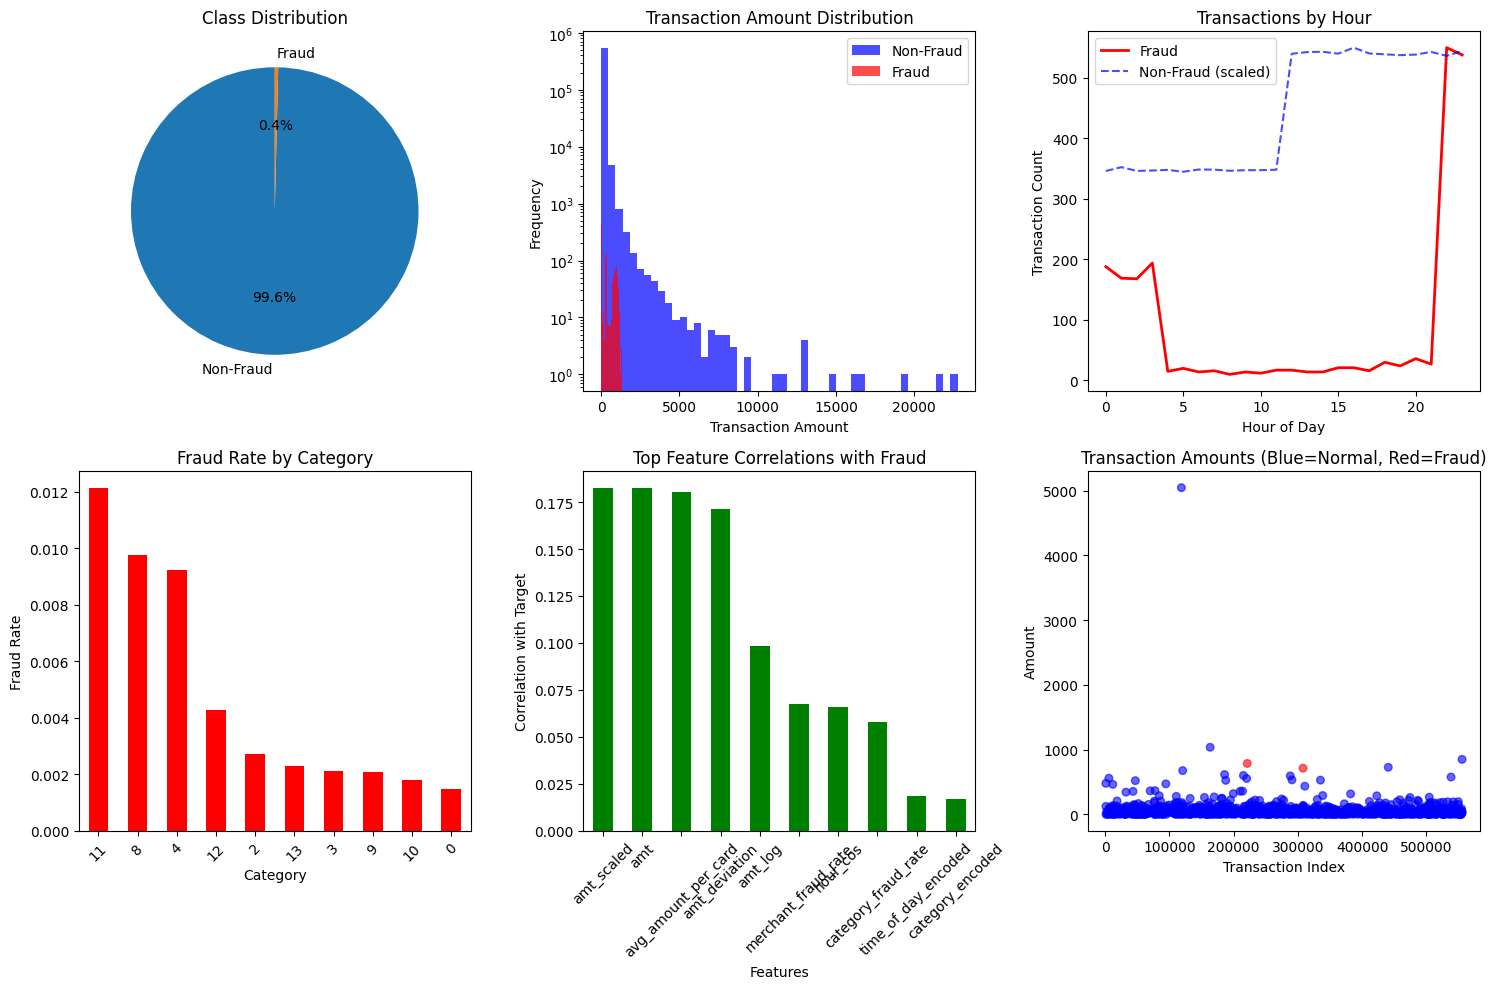


FRAUD STATISTICS:
------------------------------
Average Fraud Amount: $528.36
Average Non-Fraud Amount: $67.61
Max Fraud Amount: $1320.92
Most Common Fraud Hour: 22

DATA PREPARATION FOR MODELING
Training set shape: (444575, 32)
Test set shape: (111144, 32)
Training fraud rate: 0.3860%
Test fraud rate: 0.3860%

TESTING WITH SAMPLING METHOD: SMOTE

MODEL TRAINING & EVALUATION

Applying SMOTE to handle class imbalance...
Original fraud rate: 0.003860 (0.3860%)
Using SMOTE with k_neighbors=5
Before resampling: (444575, 32), Fraud rate: 0.385987%
After resampling: (885718, 32), Fraud rate: 50.000000%

Training Logistic Regression...
Training time: 32.41s
Accuracy: 0.9419
Precision: 0.0544
Recall: 0.8578
F1-Score: 0.1023
ROC-AUC: 0.9650
PR-AUC: 0.2206

Training Random Forest...
Training time: 181.78s
Accuracy: 0.9903
Precision: 0.2602
Recall: 0.8159
F1-Score: 0.3946
ROC-AUC: 0.9851
PR-AUC: 0.6782

Training Balanced Random Forest...
Training time: 238.86s
Accuracy: 0.9900
Precision: 0.2531

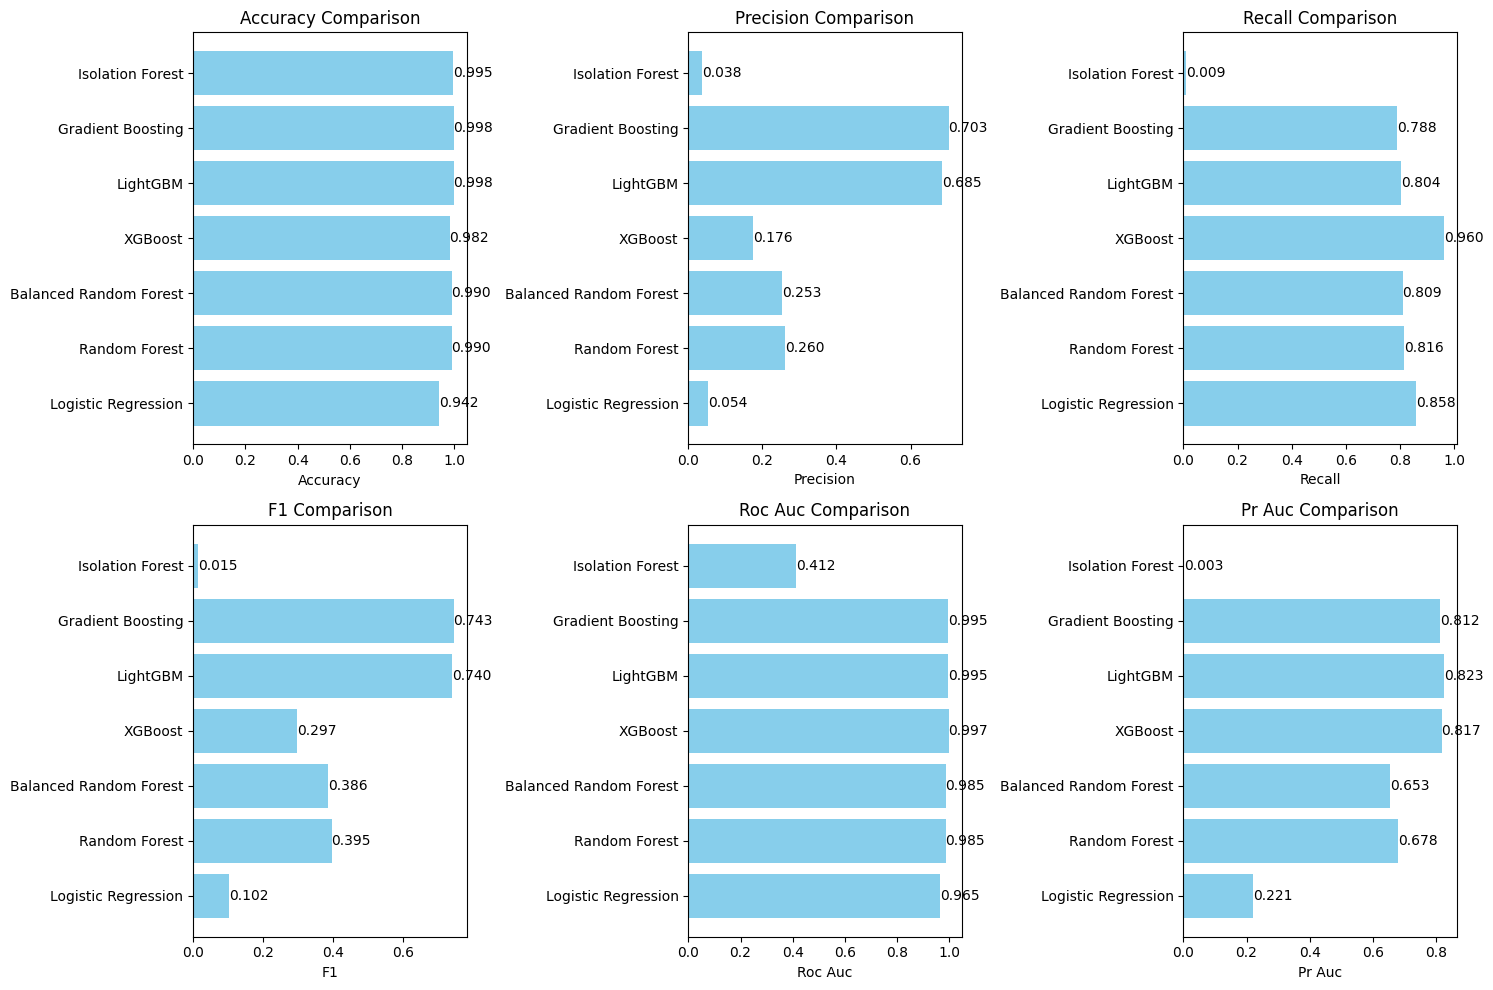

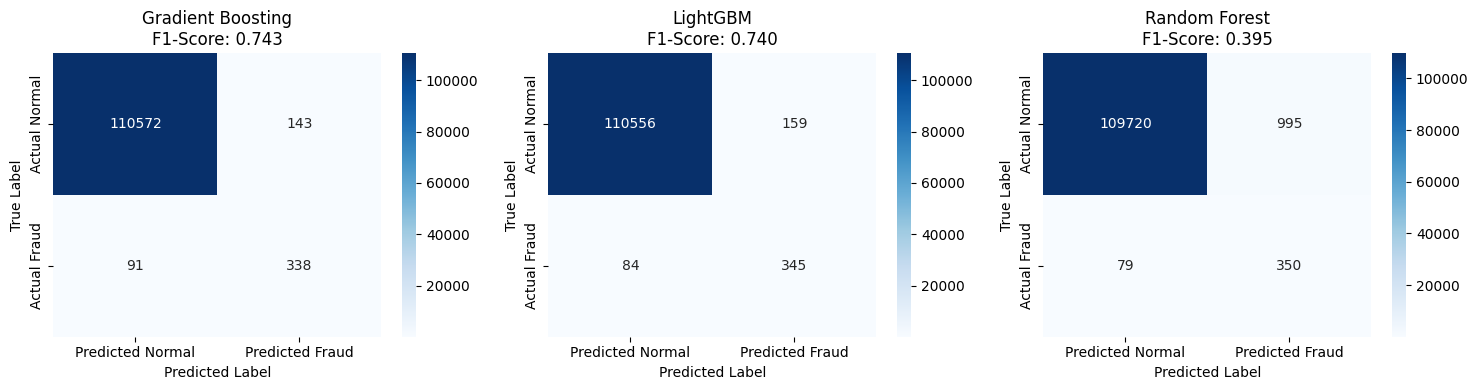


DETAILED MODEL COMPARISON
Model                     Accuracy   Precision  Recall     F1-Score   ROC-AUC   
---------------------------------------------------------------------------
Logistic Regression       0.9419     0.0544     0.8578     0.1023     0.9650    
Random Forest             0.9903     0.2602     0.8159     0.3946     0.9851    
Balanced Random Forest    0.9900     0.2531     0.8089     0.3856     0.9851    
XGBoost                   0.9825     0.1760     0.9604     0.2975     0.9967    
LightGBM                  0.9978     0.6845     0.8042     0.7395     0.9945    
Gradient Boosting         0.9979     0.7027     0.7879     0.7429     0.9949    
Isolation Forest          0.9953     0.0381     0.0093     0.0150     0.4119    

Performing hyperparameter tuning for Gradient Boosting...

HYPERPARAMETER TUNING FOR Gradient Boosting

Applying SMOTE to handle class imbalance...
Original fraud rate: 0.003860 (0.3860%)
Using SMOTE with k_neighbors=5
Before resampling: (444575, 3

In [17]:
if __name__ == "__main__":
    # Run the complete pipeline
    main()
    
    # Example of using the FraudDetector class
    print("\n" + "="*70)
    print("EXAMPLE: USING FRAUD DETECTOR FOR REAL-TIME PREDICTION")
    print("="*70)
    
    # Create example transaction
    example_transaction = {
        'amt': 2500.00,
        'hour': 3,
        'day_of_week': 6,
        'category_encoded': 7,
        'gender_encoded': 0,
        'amt_log': np.log1p(2500),
        'transaction_freq': 2,
        'avg_amount_per_card': 150.0,
        'amt_deviation': 2350.0,
        'merchant_fraud_rate': 0.15,
        'category_fraud_rate': 0.12,
        'hour_sin': np.sin(2 * np.pi * 3/24),
        'hour_cos': np.cos(2 * np.pi * 3/24)
    }
    
    # Initialize and use detector (if model exists)
    try:
        detector = FraudDetector()
        if detector.model is not None:
            result = detector.predict(example_transaction)
            print("\nExample Prediction Result:")
            print("-" * 40)
            for key, value in result.items():
                print(f"{key:20}: {value}")
    except:
        print("\nModel not found. Please run the main pipeline first to train and save the model.")
    
    print("\n" + "="*70)
    print("FRAUD DETECTION PIPELINE COMPLETE")
    print("="*70)